# ECE 498 DS Mini Project 2 - Template

### Teammates: Rongqi Gao (rongqig2), Yilin Zhu (yilinz10), Jiashuo Tong (jtong8)

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [1]:
'''
Import the data as DataFrames
'''
import csv
import pandas as pd

df_QC = pd.read_csv('Data/QualityControl.csv')
df_BIHE0 = pd.read_csv('Data/BayesInferenceHE0.csv')
df_BIHE1 = pd.read_csv('Data/BayesInferenceHE1.csv')
df_RAHE0 = pd.read_csv('Data/RelativeAbundance_HE0.csv')
df_RAHE1 = pd.read_csv('Data/RelativeAbundance_HE1.csv')

### 1. Answer: 

Using multiple samples, we will be more confident in rejecting a null hypothesis if a significantly altered abundance occurs. If we use a two-sample Z-test, larger sample sizes will yield a larger Z score, which allows us to reject H_0 with greater confidence level. If we use a two sample K-S test, larger sample sizes will give smaller critical values (on the right hand side). Thus, we can achieve higher confidence level with the same D value (K–S statistic).

### 2. Answer: 764 samples were analyzed.

In [2]:
'''
How many samples were analyzed?
'''

num_samples = len(df_RAHE0.columns)-1
print(num_samples)

764


### 3. 149 microbes were identified.

In [3]:
'''
How many microbes were identified?
'''
num_microbes = len(df_RAHE0.index)
print(num_microbes)

149


## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

$P(Q, C, LT, ST, CM) = P(Q|C, LT) \times P(C|ST, CM) \times P(ST) \times P(CM) \times P(LT)$ <br>
where Q denotes "Quality", C "Contamination", LT "Lab Time", ST "Storage Temp", and CM "Collection Method" 

### b. Parameters Required
$P(Q|C, LT)$ needs $(2-1)\times 2\times 2=4$ parameters; <br>
$P(C|ST, CM)$ needs $(2-1)\times 2\times 2=4$ parameters; <br>
$1$ parameter is needed for each of $P(ST)$, $P(CM)$ and $P(LT)$. <br>
Therefore, a total of 11 parameters will be needed to define conditional probability distribution of the Bayesian Network for quality control.

### c. Constructing Probability Tables

In [4]:
# Create the conditional probability tables using the pivot_table function
Tab1 = df_QC.pivot_table(index=['cont','labtime'], columns='qual', values='coll', fill_value=0, aggfunc='count')
Tab2 = df_QC.pivot_table(index=['strtmp','coll'], columns='cont', values='labtime', fill_value=0, aggfunc='count')
Tab3 = df_QC.pivot_table(columns='strtmp', values='coll', fill_value=0, aggfunc='count')
Tab4 = df_QC.pivot_table(columns='coll', values='strtmp', fill_value=0, aggfunc='count')
Tab5 = df_QC.pivot_table(columns='labtime', values='coll', fill_value=0, aggfunc='count')

# Normalize each row of the table so that conditional probabilities are shown
Tab1 = Tab1.div(Tab1.sum(axis=1), axis=0)
Tab2 = Tab2.div(Tab2.sum(axis=1), axis=0)
Tab3 = Tab3.div(Tab3.sum(axis=1), axis=0)
Tab4 = Tab4.div(Tab4.sum(axis=1), axis=0)
Tab5 = Tab5.div(Tab5.sum(axis=1), axis=0)

# Display the conditional probability tables
display(Tab1, Tab2, Tab3, Tab4, Tab5);

qual               bad      good
cont labtime                    
high long     0.966102  0.033898
     short    0.064257  0.935743
low  long     0.080997  0.919003
     short    0.042907  0.957093

cont                high       low
strtmp coll                       
cold   nurse    0.043983  0.956017
       patient  0.076577  0.923423
cool   nurse    0.088435  0.911565
       patient  0.838235  0.161765

strtmp,cold,cool
coll,0.8982,0.1018


coll,nurse,patient
strtmp,0.8976,0.1024


labtime,long,short
coll,0.2044,0.7956


### d. Final Probability Tables

In [5]:
# Prepare lists of possible values for each random variable
strtmp_list = ["cold", "cool"]
coll_list = ["nurse", "patient"]
labtime_list = ["long", "short"]
cont_list = ["high", "low"]

# Prepare a data dictionary for the final probability table
probs = {"strtmp": [],
         "coll": [], 
         "labtime": [],
         "good": [],
         "bad": []}

# Use a for loop to compute the conditional probability for each set of conditions, 
# including storage temperature (ST), collection method (CM), and lab time (LT)
for strtmp in strtmp_list:
    for coll in coll_list:
        for labtime in labtime_list:
            probs["strtmp"].append(strtmp)
            probs["coll"].append(coll)
            probs["labtime"].append(labtime)
            # Simply count number of good samples given the conditions
            num_good = df_QC[(df_QC['strtmp'] == strtmp) & (df_QC['coll'] == coll) & (df_QC['labtime'] == labtime) & (df_QC['qual'] == 'good')].count()[0]
            # Simply count number of bad samples given the conditions
            num_bad = df_QC[(df_QC['strtmp'] == strtmp) & (df_QC['coll'] == coll) & (df_QC['labtime'] == labtime) & (df_QC['qual'] == 'bad')].count()[0]
            # Calculate the total number of samples given 
            total = num_good+num_bad
            # P(Q=good|LT,ST,CM) = N(Q=good,LT,ST,CM)/N(LT,ST,CM)
            probs['good'].append(num_good/total)
            # P(Q=bad|LT,ST,CM) = N(Q=bad,LT,ST,CM)/N(LT,ST,CM)
            probs['bad'].append(num_bad/total)

final_cpt = pd.DataFrame(probs) # Construct the DataFrame using the data dictionary
display(final_cpt)

'''Easy Method: Directly Use pivot_table()
final_cpt = df_QC.pivot_table(index=['strtmp','coll','labtime'], columns='qual', values='cont', fill_value=0, aggfunc='count')
final_cpt = final_cpt.div(final_cpt.sum(axis=1), axis=0)
display(final_cpt)
'''

,strtmp,coll,labtime,good,bad
0,cold,nurse,long,0.887962,0.112038
1,cold,nurse,short,0.955112,0.044888
2,cold,patient,long,0.862069,0.137931
3,cold,patient,short,0.943978,0.056022
4,cool,nurse,long,0.822785,0.177215
5,cool,nurse,short,0.972376,0.027624
6,cool,patient,long,0.117647,0.882353
7,cool,patient,short,0.960784,0.039216


"Easy Method: Directly Use pivot_table()\nfinal_cpt = df_QC.pivot_table(index=['strtmp','coll','labtime'], columns='qual', values='cont', fill_value=0, aggfunc='count')\nfinal_cpt = final_cpt.div(final_cpt.sum(axis=1), axis=0)\ndisplay(final_cpt)\n"

### e. Cleaning the dataset


In [6]:
print("1e. According to the CPT from 1d, bad quality sample are those with conditions strtmp=cool, coll=patient, and labtime=long.")
# Find name of bad samples from BayesInferenceHE0.csv and BayesInferenceHE1.csv
bad_sample_names_BIHE0 = df_BIHE0[(df_BIHE0['strtmp']=='cool') & (df_BIHE0['coll']=='patient') & (df_BIHE0['labtime']=='long')]['SampleName']
bad_sample_names_BIHE1 = df_BIHE1[(df_BIHE1['strtmp']=='cool') & (df_BIHE1['coll']=='patient') & (df_BIHE1['labtime']=='long')]['SampleName']
print("Bad samples are from HE0Sample_699 t0 HE0Sample_763, and HE1Sample_699 t0 HE1Sample_763.")
# Remove bad samples from df_RAHE0 and df_RAHE1
for i in range(699, 764): 
    df_RAHE0 = df_RAHE0.drop(['HE0Sample_'+str(i)], axis=1)
    df_RAHE1 = df_RAHE1.drop(['HE1Sample_'+str(i)], axis=1)

display(df_RAHE0.head(5))
display(df_RAHE1.head(5))

1e. According to the CPT from 1d, bad quality sample are those with conditions strtmp=cool, coll=patient, and labtime=long.
Bad samples are from HE0Sample_699 t0 HE0Sample_763, and HE1Sample_699 t0 HE1Sample_763.


,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_689,HE0Sample_690,HE0Sample_691,HE0Sample_692,HE0Sample_693,HE0Sample_694,HE0Sample_695,HE0Sample_696,HE0Sample_697,HE0Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004681,0.005588,0.004256,0.003755,0.004995,0.006198,0.006096,0.003961,0.003970,0.005229
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.007489,0.011874,0.011103,0.014661,0.009301,0.010331,0.012716,0.011195,0.011731,0.014642
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.005055,0.002095,0.005736,0.004291,0.006545,0.004132,0.004877,0.004823,0.001985,0.004532
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.004306,0.003318,0.004626,0.004112,0.004823,0.005447,0.004877,0.003961,0.003609,0.003486
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.005242,0.002445,0.005736,0.005006,0.004306,0.004884,0.002613,0.004650,0.005234,0.004183


,Microbe Name,HE1Sample_0,HE1Sample_1,HE1Sample_2,HE1Sample_3,HE1Sample_4,HE1Sample_5,HE1Sample_6,HE1Sample_7,HE1Sample_8,...,HE1Sample_689,HE1Sample_690,HE1Sample_691,HE1Sample_692,HE1Sample_693,HE1Sample_694,HE1Sample_695,HE1Sample_696,HE1Sample_697,HE1Sample_698
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004864,0.004041,0.005630,0.005046,0.005041,0.005278,0.004005,0.003700,0.004295,...,0.005573,0.004854,0.005412,0.004985,0.004070,0.003940,0.003880,0.004454,0.003743,0.005301
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.011985,0.012124,0.010732,0.012074,0.009001,0.012559,0.013234,0.011284,0.011391,...,0.010786,0.011963,0.011571,0.010657,0.013136,0.009381,0.012875,0.009280,0.010479,0.009322
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.005211,0.003866,0.004926,0.004505,0.005401,0.005461,0.005050,0.003330,0.003922,...,0.004494,0.004508,0.002613,0.005672,0.003330,0.005253,0.004409,0.005011,0.005801,0.005301
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003995,0.003866,0.004046,0.005406,0.003600,0.006189,0.003308,0.004255,0.004482,...,0.004494,0.005721,0.004479,0.002922,0.005365,0.004503,0.003527,0.005568,0.004304,0.006946
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.002953,0.003514,0.004574,0.005046,0.003420,0.004186,0.004701,0.004624,0.003361,...,0.002876,0.003467,0.004479,0.002922,0.003885,0.004690,0.004233,0.006496,0.003743,0.006215


## 2. Data Standardization

### 1. Verify Relative Abundance

In [7]:
for term in df_RAHE0.sum(axis=0)[1:]:
    if (term - 1.0) > 1e-10:
        print("The provided data has samples which do not follow the constraints.")
print("The relative abundance data from 'RelativeAbundance_HE0.csv' is all qualified.")

for term in df_RAHE1.sum(axis=0)[1:]:
    if (term - 1.0) > 1e-10:
        print("The provided data has samples which do not follow the constraints.")    
print("The relative abundance data from 'RelativeAbundance_HE1.csv' is all qualified.")

The relative abundance data from 'RelativeAbundance_HE0.csv' is all qualified.
The relative abundance data from 'RelativeAbundance_HE1.csv' is all qualified.


### 2. Discussion on Relative Abundance Data

In [8]:
print("Advantage: The absolute abundance for microbes might vary from person to person, so it cannot be used to measure the abundance level. The relative abundance is a standardized variable, so we can use it to compare the abundance levels of two samples.\n")
print("Drawback: The relative abundance loses information about how much of each microbe exists. This information can be critical in the sense that the amount of microbes may also change to whether a person has HE or not.")

Advantage: The absolute abundance for microbes might vary from person to person, so it cannot be used to measure the abundance level. The relative abundance is a standardized variable, so we can use it to compare the abundance levels of two samples.

Drawback: The relative abundance loses information about how much of each microbe exists. This information can be critical in the sense that the amount of microbes may also change to whether a person has HE or not.


## 3. Visual Inspection

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import savefig

#print(df_RAHE0.drop(['Microbe Name'], axis=1).values.max())
#print(df_RAHE1.drop(['Microbe Name'], axis=1).values.max())

plt.subplots(figsize=(20,15))
ax1 = sns.heatmap(df_RAHE0.drop(['Microbe Name'], axis=1).values, vmin=0, vmax=0.025)
ax1.set_title("Heat Map of Microbe Abundance for HE0", fontsize=18)
ax1.set_xlabel("Sample No.", fontsize=12)
ax1.set_ylabel("Microbe No.", fontsize=12)
ax1.get_figure().savefig('ax1.png', dpi=400)

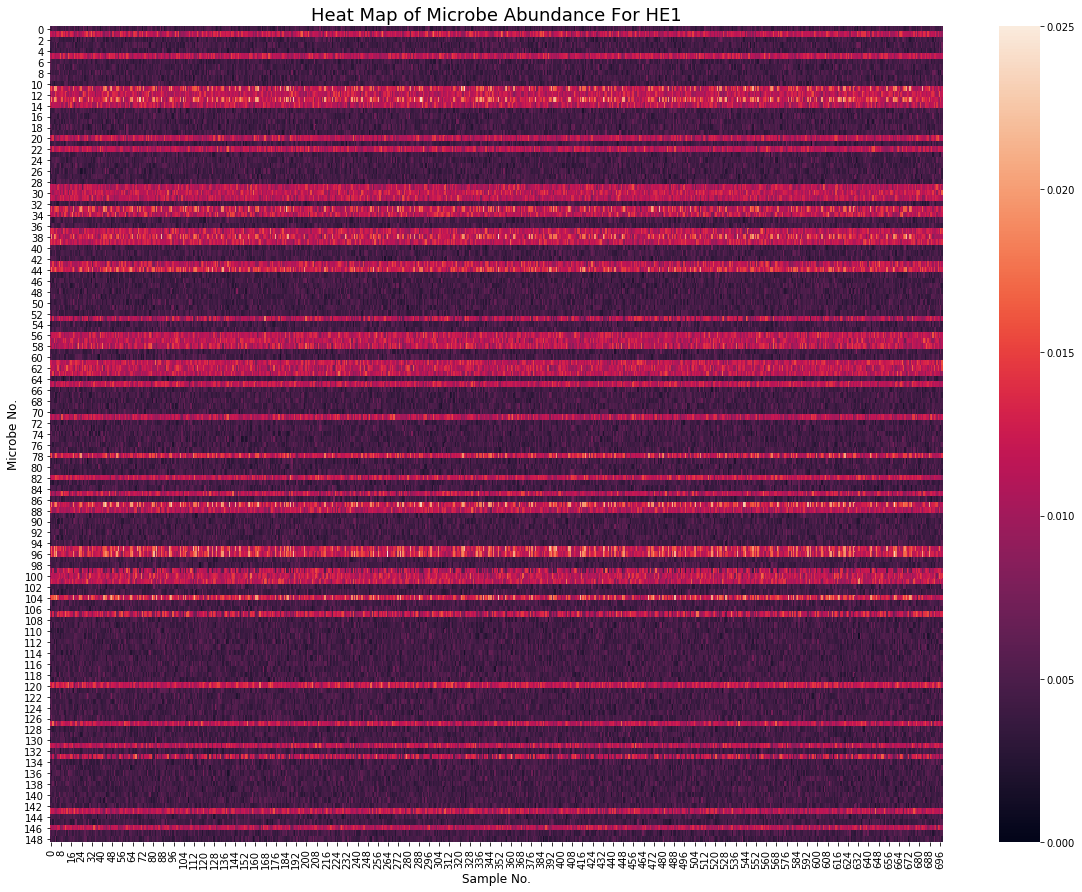

In [10]:
plt.subplots(figsize=(20,15))
ax2 = sns.heatmap(df_RAHE1.drop(['Microbe Name'], axis=1).values, vmin=0, vmax=0.025)
ax2.set_title("Heat Map of Microbe Abundance For HE1", fontsize=18)
ax2.set_xlabel("Sample No.", fontsize=12)
ax2.set_ylabel("Microbe No.", fontsize=12)
ax2.get_figure().savefig('ax2.png', dpi=400)

In [11]:
print('From the two heatmaps, we could find that the pattern of the relative abundance of microbe of HE0 and HE1 samples are approximately the same, for each sample the relative abundance of microbe is similar.')
print('\nPros: The heatmaps are good at highlighting the data distribute pattern of a two-dimensional data set. Since it uses color to represent the amount of each data point, we can easily find out how the larger and smaller data points distributed. And for the same reason, we can easily get the information from a huge data set.')
print('\nCons: The shortcoming of heatmaps is that we are poor at comparing the amount of data points in non-adjacent regions, in some situations we might misread the heatmaps.')

From the two heatmaps, we could find that the pattern of the relative abundance of microbe of HE0 and HE1 samples are approximately the same, for each sample the relative abundance of microbe is similar.

Pros: The heatmaps are good at highlighting the data distribute pattern of a two-dimensional data set. Since it uses color to represent the amount of each data point, we can easily find out how the larger and smaller data points distributed. And for the same reason, we can easily get the information from a huge data set.

Cons: The shortcoming of heatmaps is that we are poor at comparing the amount of data points in non-adjacent regions, in some situations we might misread the heatmaps.


# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [12]:
import numpy as np
from scipy.stats import ks_2samp
num_microbes = len(df_RAHE0["Microbe Name"])
microbe_name = list(df_RAHE0["Microbe Name"])
p_values = []
for i in range(num_microbes):
    dist_RAHE0 = df_RAHE0.iloc[i, 1:]
    dist_RAHE1 = df_RAHE1.iloc[i, 1:]
    p_value = ks_2samp(dist_RAHE1, dist_RAHE0).pvalue
    p_values.append(p_value)
data = {"Microbe Name": microbe_name, "P Values": p_values}
df_pvalues = pd.DataFrame(data)
df_pvalues.head()

,Microbe Name,P Values
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.174666
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.002451
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.106124
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.531570
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.933888


In [13]:
import scipy
scipy.version.version

'1.2.1'

### b. Null Hypothesis of the KS Test in our Context

In [14]:
print("For the KS test on the microbe 'Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter', our null hypothesis is that the HE0 samples and HE1 samples obey the same distribution.")

For the KS test on the microbe 'Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter', our null hypothesis is that the HE0 samples and HE1 samples obey the same distribution.


### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [15]:
levels = [0.1, 0.05, 0.01, 0.005, 0.001]

num_altered = []
for level in levels:
    count = df_pvalues[df_pvalues["P Values"] < level].count()[0]
    num_altered.append(count)

data = {"Confidence Level": levels , "Number of Significantly Altered Microbes": num_altered}
df_altered = pd.DataFrame(data)

df_altered

,Confidence Level,Number of Significantly Altered Microbes
0,0.100,50
1,0.050,37
2,0.010,27
3,0.005,26
4,0.001,21


## 2. Multiple Testing

### a. P-value

In [16]:
print("A p-value of 0.05 from KS test on a microbe means the probability of observing the HE0 & HE1 samples is only 5%, given that the null hypothesis (the microbe is not altered) is true. ")

A p-value of 0.05 from KS test on a microbe means the probability of observing the HE0 & HE1 samples is only 5%, given that the null hypothesis (the microbe is not altered) is true. 


### b. P-value Distribution

In [17]:
print("The answer is Uniform distribution. The p-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct. Thus, given the null hypothesis is true, the cdf for the random variable P will be F(P) =  P. The corresponding pdf will be f(P) = 1, which is Uniform distribution")

The answer is Uniform distribution. The p-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct. Thus, given the null hypothesis is true, the cdf for the random variable P will be F(P) =  P. The corresponding pdf will be f(P) = 1, which is Uniform distribution


### c. Expected Number of Significant p-values

In [18]:
levels = [0.1, 0.05, 0.01, 0.005, 0.001]

num_significant = num_altered
num_significant_given_h0 = [int(num_microbes*level) for level in levels]

data = {"Confidence Level": levels , "Number of Significant P-values": num_significant, "Number of Significant P-values Given H0": num_significant_given_h0}
df_comparison = pd.DataFrame(data)
display(df_comparison)

,Confidence Level,Number of Significant P-values,Number of Significant P-values Given H0
0,0.100,50,14
1,0.050,37,7
2,0.010,27,1
3,0.005,26,0
4,0.001,21,0


### d. Q-Q plot of p-values

#### i. Sample N p-values from the expected distribution in Task 2.2.b (referred to as expected p-values).

In [19]:
N = num_microbes
expected_pvalues = np.random.uniform(0,1,N)
observed_pvalues = list(df_pvalues["P Values"])

#### ii. Take the -log10() of observed p-values and expected p-values.

In [20]:
expected_pvalues_log = -np.log10(expected_pvalues)
observed_pvalues_log = -np.log10(observed_pvalues)

#### iii. Rank observed p-values and expected p-values in ascending order separately.

In [21]:
expected_pvalues_log.sort()
observed_pvalues_log.sort()

#### iv. Take the pair of smallest p-values (one from observed p-values, one from expected p-values) and plot a point on an x-y plot with the observed p-value on the Y-axis and the expected p-value on the X-axis.

Text(0, 0.5, 'Observed P-values')

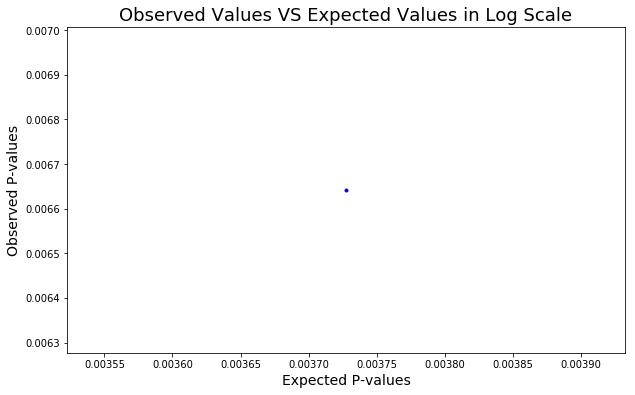

In [22]:
import matplotlib.pyplot as plt

x = expected_pvalues_log[0]
y = observed_pvalues_log[0]

fig = plt.figure(1, figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y, ".", color="b")
ax.set_title("Observed Values VS Expected Values in Log Scale", fontsize=18)
ax.set_xlabel("Expected P-values", fontsize=14)
ax.set_ylabel("Observed P-values", fontsize=14)

#### v. Repeat (iv) for the next smallest pair, for the next smallest, and so on until you have plotted all N pairs in order.

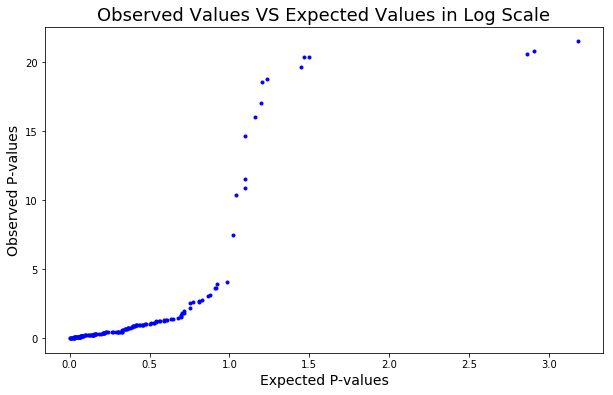

In [23]:
import matplotlib.pyplot as plt

xs = expected_pvalues_log
ys = observed_pvalues_log

fig = plt.figure(figsize=(10,6))

for x, y in zip(xs, ys):
    plt.plot(x, y, marker=".", color="b")

plt.title("Observed Values VS Expected Values in Log Scale", fontsize=18)
plt.xlabel("Expected P-values", fontsize=14)
plt.ylabel("Observed P-values", fontsize=14)
plt.show()

#### vi. Add the x=y line to your plot.

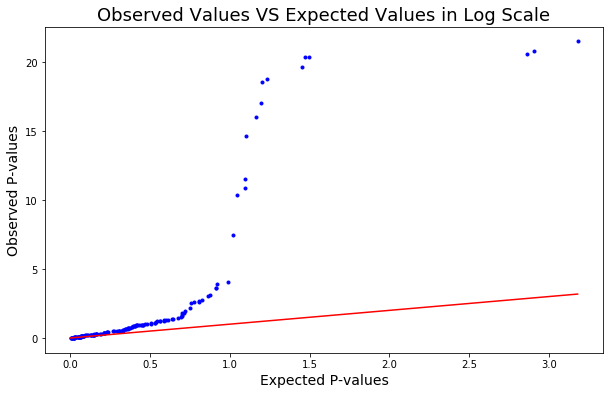

In [24]:
import matplotlib.pyplot as plt

xs = expected_pvalues_log
ys = observed_pvalues_log

fig = plt.figure(figsize=(10,6))

for x, y in zip(xs, ys):
    plt.plot(x, y, marker=".", color="b")
    
lvalues = np.linspace(0,expected_pvalues_log[-1],10)
plt.plot(lvalues, lvalues, color="r")

plt.title("Observed Values VS Expected Values in Log Scale", fontsize=18)
plt.xlabel("Expected P-values", fontsize=14)
plt.ylabel("Observed P-values", fontsize=14)
plt.show()

### e. Follow-up Questions

#### i. How does taking the -log10() of the p-values help you visualize the p-value distribution?

In [25]:
print("Taking the -log10() of the p-values magnifies the deviation of the observed from the expected. Say we have a data point (0.001, 0.1). If it is plotted with the original values, it will be very close to the x=y line. The -log10() values, which are (3,1), stay off x=y by a large margin. Thus, if we used the original p-values, we would have created an approximately 'linear' curve (as shown in the following cell), and we would have drawn a wrong conclusion. Hence, the -log10() values help us easily identify the non-linear nature of the curve which leads to the correct conclusion.")

Taking the -log10() of the p-values magnifies the deviation of the observed from the expected. Say we have a data point (0.001, 0.1). If it is plotted with the original values, it will be very close to the x=y line. The -log10() values, which are (3,1), stay off x=y by a large margin. Thus, if we used the original p-values, we would have created an approximately 'linear' curve (as shown in the following cell), and we would have drawn a wrong conclusion. Hence, the -log10() values help us easily identify the non-linear nature of the curve which leads to the correct conclusion.


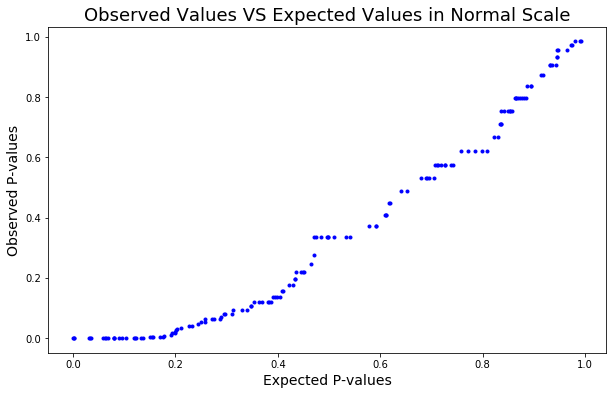

In [26]:
import matplotlib.pyplot as plt

xs = sorted(expected_pvalues)
ys = sorted(observed_pvalues)


fig = plt.figure(figsize=(10,6))

for x, y in zip(xs, ys):
    plt.plot(x, y, marker=".", color="b")

plt.title("Observed Values VS Expected Values in Normal Scale", fontsize=18)
plt.xlabel("Expected P-values", fontsize=14)
plt.ylabel("Observed P-values", fontsize=14)
plt.show()

#### ii. What can you conclude from the Q-Q plot? (Hint: Think about what it means if the Q-Q plot approximately aligns or doesn’t align with the x=y line and what it implies about the null hypothesis.)

In [27]:
print("We can conclude from the Q-Q plot that the null hypothesis should be rejected.\n\nReason: If the null hypothesis is true, the Q-Q plot should approximately aligns with the x=y line. However, our Q-Q plot obviously deviates from the x=y line. Therefore, the null hypothesis is likely to be false.")

We can conclude from the Q-Q plot that the null hypothesis should be rejected.

Reason: If the null hypothesis is true, the Q-Q plot should approximately aligns with the x=y line. However, our Q-Q plot obviously deviates from the x=y line. Therefore, the null hypothesis is likely to be false.


# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCAs on RA data for HE0 and HE1
PCAHE0 = PCA(n_components=df_RAHE0.shape[0], svd_solver='full')
data0 = np.array(df_RAHE0.drop(['Microbe Name'], axis=1)).T
PCAHE0.fit(data0)
PCAHE1 = PCA(n_components=df_RAHE1.shape[0], svd_solver='full')
data1 = np.array(df_RAHE1.drop(['Microbe Name'], axis=1)).T
PCAHE1.fit(data1)

PCA(copy=True, iterated_power='auto', n_components=149, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)


### b. Ordering Components

Text(0, 0.5, 'Fraction of Total Variance')

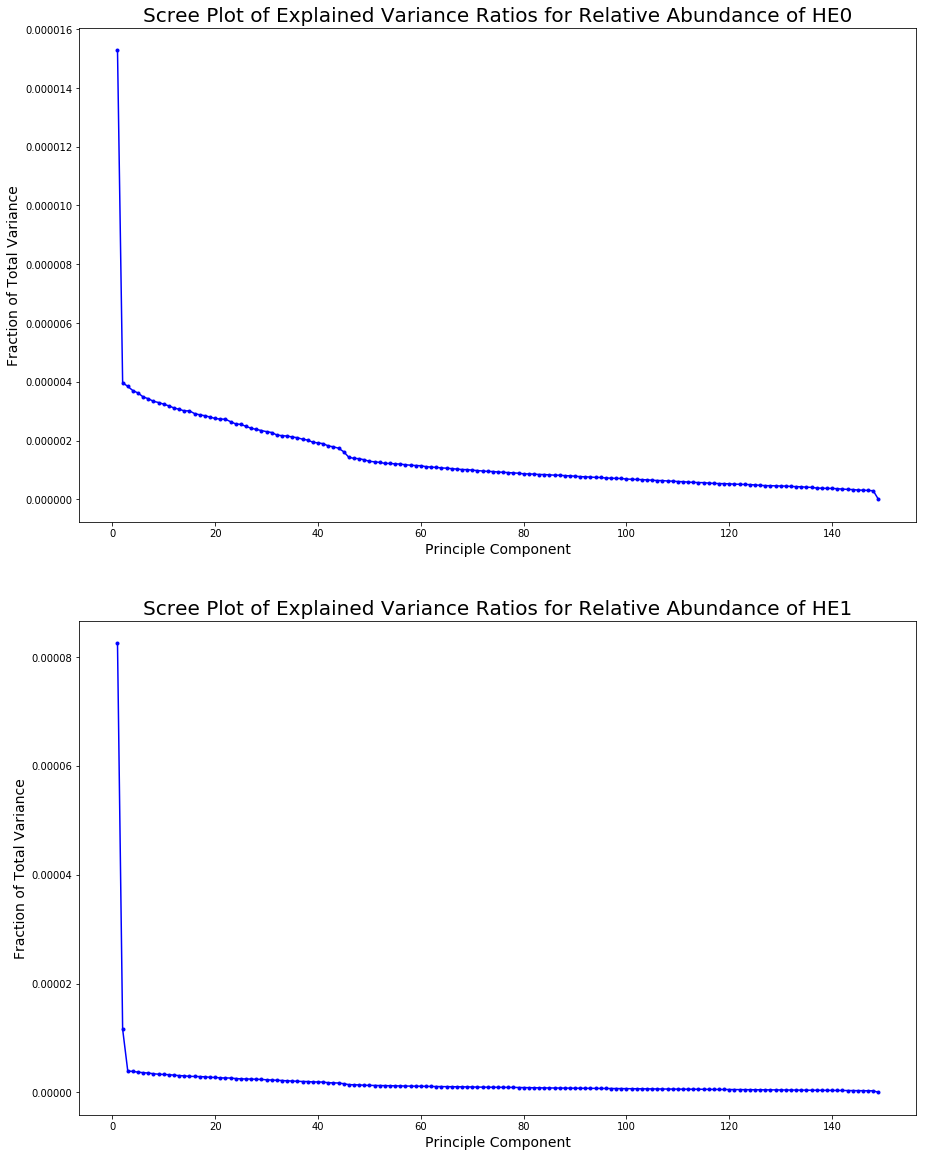

In [29]:
# Prepare data points for plotting
pcs = np.array([i for i in range(1, 150)])
variancesHE0 = np.array(PCAHE0.explained_variance_)
variancesHE1 = np.array(PCAHE1.explained_variance_)
df_pcsHE0 = pd.DataFrame({"pcs" : pcs, "variances": variancesHE0})
df_pcsHE1 = pd.DataFrame({"pcs" : pcs, "variances": variancesHE1})
# Create Plots
fig, ax = plt.subplots(2, 1, figsize=(15,20))
ax[0].plot(df_pcsHE0['pcs'], df_pcsHE0['variances'], marker=".", color="b")
ax[0].set_title("Scree Plot of Explained Variance Ratios for Relative Abundance of HE0", fontsize=20)
ax[0].set_xlabel("Principle Component", fontsize=14)
ax[0].set_ylabel("Fraction of Total Variance", fontsize=14)

ax[1].plot(df_pcsHE1['pcs'], df_pcsHE1['variances'], marker=".", color="b")
ax[1].set_title("Scree Plot of Explained Variance Ratios for Relative Abundance of HE1", fontsize=20)
ax[1].set_xlabel("Principle Component", fontsize=14)
ax[1].set_ylabel("Fraction of Total Variance", fontsize=14)

In [30]:
print("Only one principal component is needed to explain 30% of the total variance")

Only one principal component is needed to explain 30% of the total variance


### c. Scatter Plot of Microbe Abundance

Text(0, 0.5, 'Projection Onto 2nd PC')

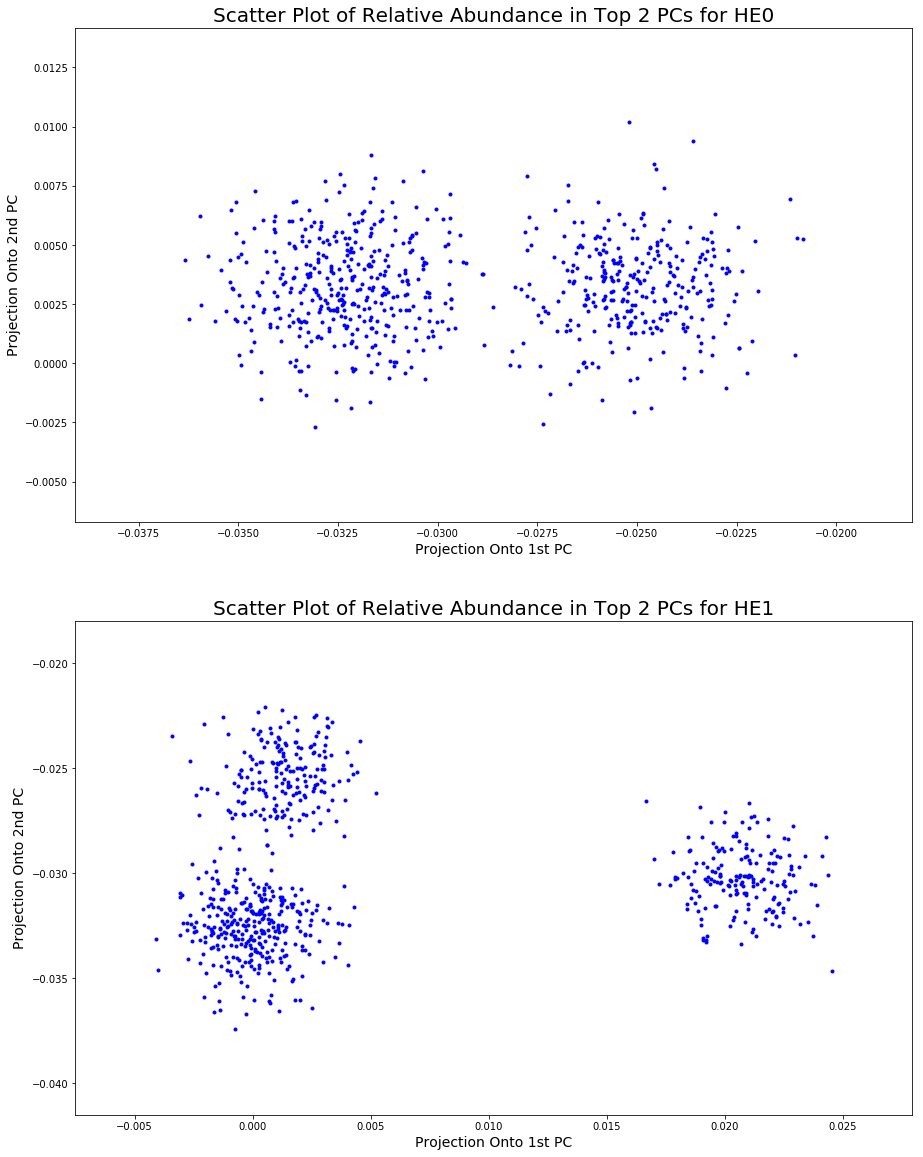

In [31]:
# Prepare the Relative Abundance data for HE0 and HE1 as NumPy arrays.
arrayHE0 = np.array(df_RAHE0.drop('Microbe Name', axis=1)).T
arrayHE1 = np.array(df_RAHE1.drop('Microbe Name', axis=1)).T

# Project relative abundance data onto the 1st and 2nd PCs for HE0
projPC1HE0 = np.inner((arrayHE0), PCAHE0.components_[0])
projPC2HE0 = np.inner((arrayHE0), PCAHE0.components_[1])
# Project relative abundance data onto the 1st and 2nd PCs for HE1
projPC1HE1 = np.inner((arrayHE1), PCAHE1.components_[0])
projPC2HE1 = np.inner((arrayHE1), PCAHE1.components_[1])

# Create Scatter Plots
fig, ax = plt.subplots(2, 1, figsize=(15,20))

ax[0].scatter(projPC1HE0, projPC2HE0, marker=".", color="b")
ax[0].set_title("Scatter Plot of Relative Abundance in Top 2 PCs for HE0", fontsize=20)
ax[0].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[0].set_ylabel("Projection Onto 2nd PC", fontsize=14)

ax[1].scatter(projPC1HE1, projPC2HE1, marker=".", color="b")
ax[1].set_title("Scatter Plot of Relative Abundance in Top 2 PCs for HE1", fontsize=20)
ax[1].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[1].set_ylabel("Projection Onto 2nd PC", fontsize=14)

In [32]:
print("Observations: After projecting the original data into 2 dimensional space (PC1 and PC2), we observed 2 clusters for HE0, and 3 clusters for HE1.")

Observations: After projecting the original data into 2 dimensional space (PC1 and PC2), we observed 2 clusters for HE0, and 3 clusters for HE1.


## 2. t-SNE

### a. Performing t-SNE

Text(0.5, 1.0, '2D RA Data Visualization for HE1, random_state=42')

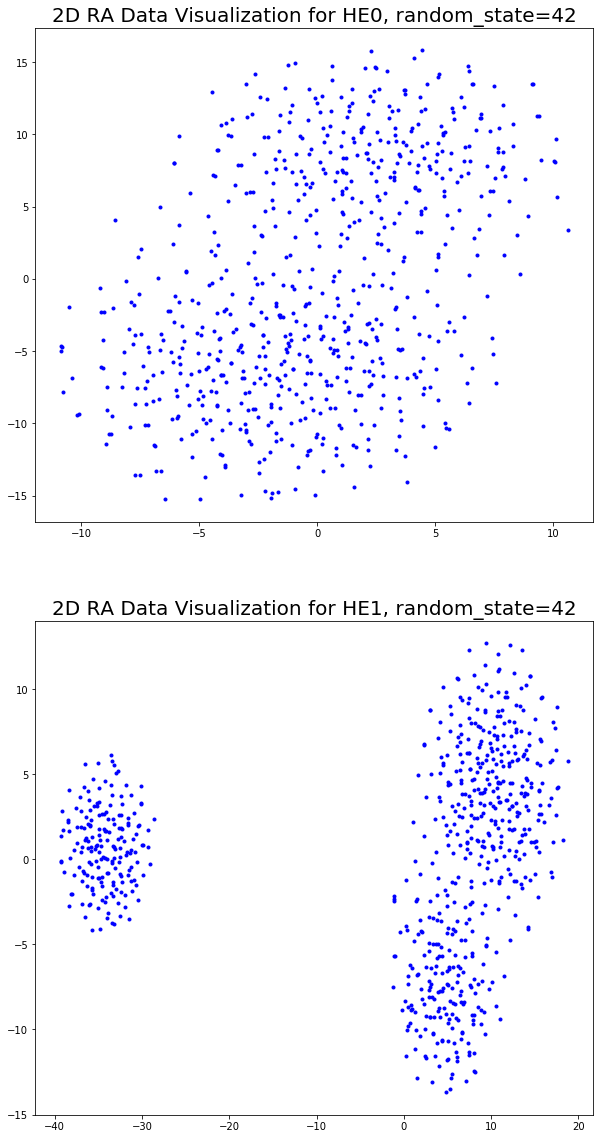

In [33]:
from sklearn.manifold import TSNE
# Perform t-SNE on RA data for HE0 and HE1
tsneHE0 = TSNE(n_components=2, random_state=42).fit_transform(arrayHE0)
tsneHE1 = TSNE(n_components=2, random_state=42).fit_transform(arrayHE1)

# Create scatter plots
fig, ax = plt.subplots(2, 1, figsize=(10,20))
ax[0].scatter(tsneHE0[:,0], tsneHE0[:,1], marker=".", color="b")
ax[0].set_title("2D RA Data Visualization for HE0, random_state=42", fontsize=20)
ax[1].scatter(tsneHE1[:,0], tsneHE1[:,1], marker=".", color="b")
ax[1].set_title("2D RA Data Visualization for HE1, random_state=42", fontsize=20)

Text(0.5, 1.0, '2D RA Data Visualization for HE1, random_state=62')

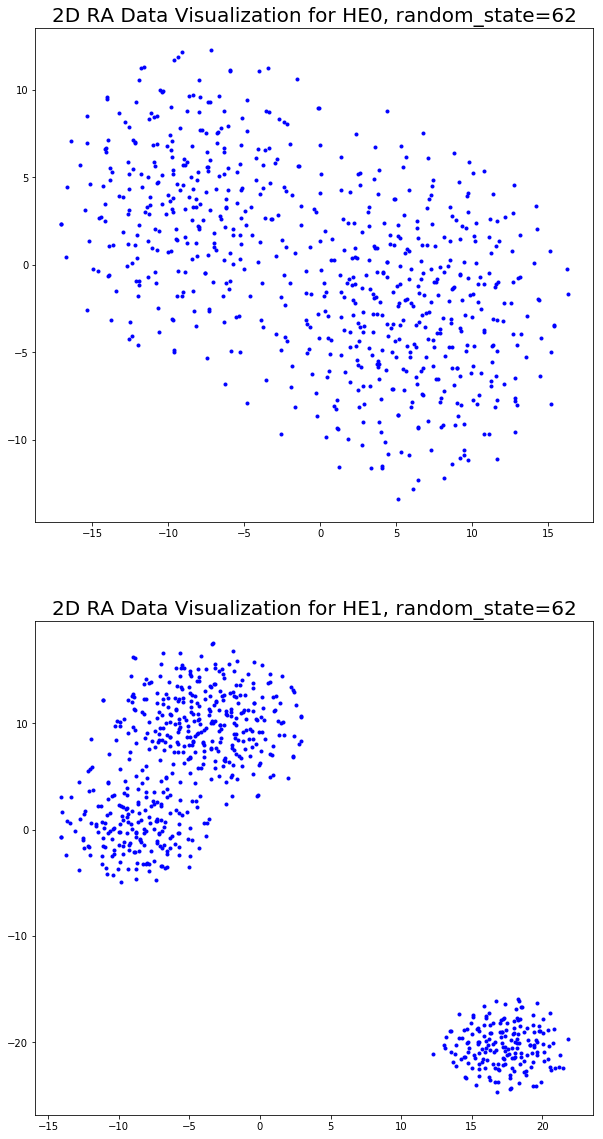

In [34]:
# Perform t-SNE on RA data for HE0 and HE1
tsneHE0 = TSNE(n_components=2, random_state=62).fit_transform(arrayHE0)
tsneHE1 = TSNE(n_components=2, random_state=62).fit_transform(arrayHE1)

# Create scatter plots
fig, ax = plt.subplots(2, 1, figsize=(10,20))
ax[0].scatter(tsneHE0[:,0], tsneHE0[:,1], marker=".", color="b")
ax[0].set_title("2D RA Data Visualization for HE0, random_state=62", fontsize=20)
ax[1].scatter(tsneHE1[:,0], tsneHE1[:,1], marker=".", color="b")
ax[1].set_title("2D RA Data Visualization for HE1, random_state=62", fontsize=20)

Text(0.5, 1.0, '2D RA Data Visualization for HE1, random_state=82')

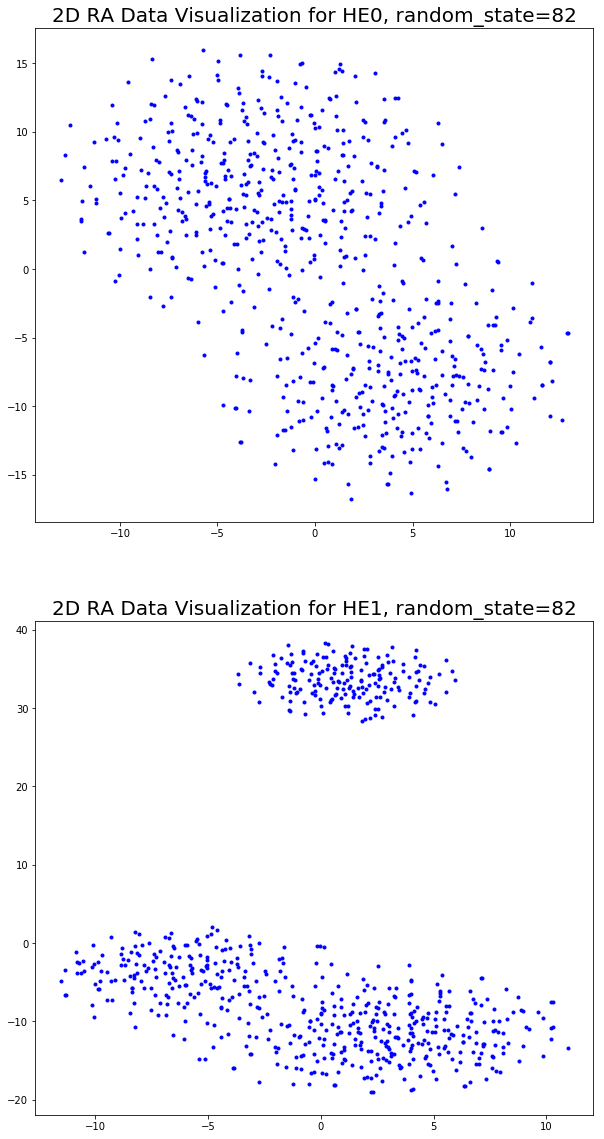

In [35]:
from sklearn.manifold import TSNE
# Perform t-SNE on RA data for HE0 and HE1
tsneHE0 = TSNE(n_components=2, random_state=82).fit_transform(arrayHE0)
tsneHE1 = TSNE(n_components=2, random_state=82).fit_transform(arrayHE1)

# Create scatter plots
fig, ax = plt.subplots(2, 1, figsize=(10,20))
ax[0].scatter(tsneHE0[:,0], tsneHE0[:,1], marker=".", color="b")
ax[0].set_title("2D RA Data Visualization for HE0, random_state=82", fontsize=20)
ax[1].scatter(tsneHE1[:,0], tsneHE1[:,1], marker=".", color="b")
ax[1].set_title("2D RA Data Visualization for HE1, random_state=82", fontsize=20)

In [36]:
print("Observation: We can identify 2 clusters for HE0, but the boundary between them is not so clear. For HE1, we identify one large cluster sitting on bottom, and one small cluster sitting on top.")

Observation: We can identify 2 clusters for HE0, but the boundary between them is not so clear. For HE1, we identify one large cluster sitting on bottom, and one small cluster sitting on top.


### b. Comparing with PCA

In [37]:
print("Similarities and differences: PCA is linear dimensionality reduction while TSNE is nonlinear dimensionality reduction. Comparing the graphs, we can see clusters have formed for both computing techniques. The HE1 graphs show that the clusters from PCA are more 'circular' than those from TSNE.")

Similarities and differences: PCA is linear dimensionality reduction while TSNE is nonlinear dimensionality reduction. Comparing the graphs, we can see clusters have formed for both computing techniques. The HE1 graphs show that the clusters from PCA are more 'circular' than those from TSNE.


## 3. Clustering

In [38]:
# Import packages needed for Task 3
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

### a. K-Means (HE0)

Text(0, 0.5, 'Projection Onto 2nd PC')

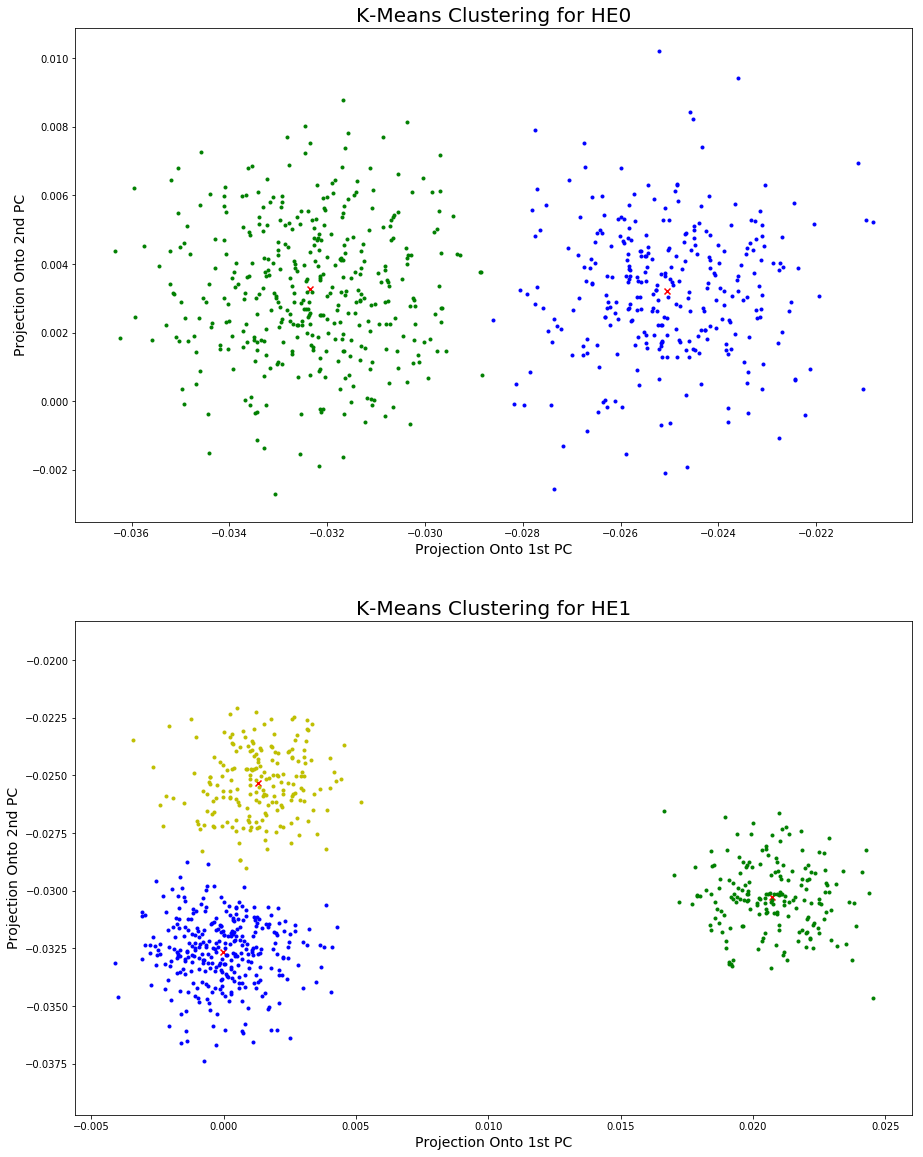

In [39]:
# Conduct k-means clustering
pointsHE0 = [[x,y] for x,y in zip(projPC1HE0, projPC2HE0)]
kmeansHE0 = KMeans(n_clusters=2, random_state=0).fit(pointsHE0)
centersHE0 = np.array(kmeansHE0.cluster_centers_)

pointsHE1 = [[x,y] for x,y in zip(projPC1HE1, projPC2HE1)]
kmeansHE1 = KMeans(n_clusters=3, random_state=0).fit(pointsHE1)
centersHE1 = np.array(kmeansHE1.cluster_centers_)

# Create two groups of indices according to the predictions
labelsHE0 = kmeansHE0.labels_
predictionsHE0 = kmeansHE0.predict(pointsHE0)
indices1HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if x])
indices2HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if not x])

labelsHE1 = kmeansHE1.labels_
indices1HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==0])
indices2HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==1])
indices3HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==2])
# Create scatter plot for HE0
fig, ax = plt.subplots(2, 1, figsize=(15,20))

ax[0].scatter(centersHE0[:,0], centersHE0[:,1], marker="x", color="r")
ax[0].scatter(indices1HE0[:,0], indices1HE0[:,1], marker=".", color="b")
ax[0].scatter(indices2HE0[:,0], indices2HE0[:,1], marker=".", color="g")
ax[0].set_title("K-Means Clustering for HE0", fontsize=20)
ax[0].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[0].set_ylabel("Projection Onto 2nd PC", fontsize=14)

ax[1].scatter(centersHE1[:,0], centersHE1[:,1], marker="x", color="r")
ax[1].scatter(indices1HE1[:,0], indices1HE1[:,1], marker=".", color="b")
ax[1].scatter(indices2HE1[:,0], indices2HE1[:,1], marker=".", color="g")
ax[1].scatter(indices3HE1[:,0], indices3HE1[:,1], marker=".", color="y")
ax[1].set_title("K-Means Clustering for HE1", fontsize=20)
ax[1].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[1].set_ylabel("Projection Onto 2nd PC", fontsize=14)

### b. GMM

Text(0, 0.5, 'Projection Onto 2nd PC')

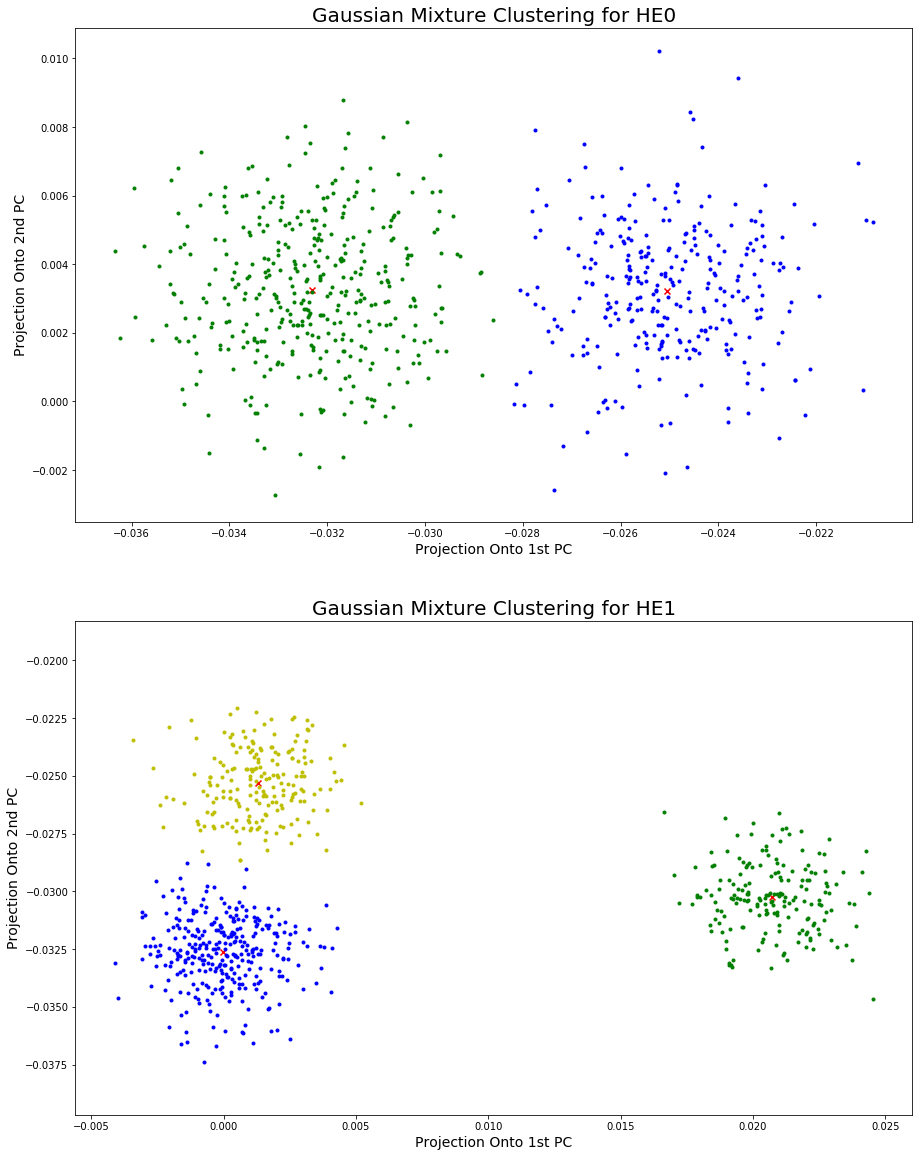

In [40]:
# Conduct k-means clustering
pointsHE0 = [[x,y] for x,y in zip(projPC1HE0, projPC2HE0)]
gmmHE0 = GaussianMixture(n_components=2, random_state=0).fit(pointsHE0)
centersHE0 = np.array(gmmHE0.means_)
labelsHE0 = gmmHE0.predict(pointsHE0)

pointsHE1 = [[x,y] for x,y in zip(projPC1HE1, projPC2HE1)]
gmmHE1 = GaussianMixture(n_components=3, random_state=0).fit(pointsHE1)
centersHE1 = np.array(gmmHE1.means_)
labelsHE1 = gmmHE1.predict(pointsHE1)

# Create two groups of indices according to the predictions
indices1HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if x])
indices2HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if not x])

indices1HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==0])
indices2HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==1])
indices3HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==2])
# Create scatter plot for HE0
fig, ax = plt.subplots(2, 1, figsize=(15,20))

ax[0].scatter(centersHE0[:,0], centersHE0[:,1], marker="x", color="r")
ax[0].scatter(indices1HE0[:,0], indices1HE0[:,1], marker=".", color="b")
ax[0].scatter(indices2HE0[:,0], indices2HE0[:,1], marker=".", color="g")
ax[0].set_title("Gaussian Mixture Clustering for HE0", fontsize=20)
ax[0].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[0].set_ylabel("Projection Onto 2nd PC", fontsize=14)

ax[1].scatter(centersHE1[:,0], centersHE1[:,1], marker="x", color="r")
ax[1].scatter(indices1HE1[:,0], indices1HE1[:,1], marker=".", color="b")
ax[1].scatter(indices2HE1[:,0], indices2HE1[:,1], marker=".", color="g")
ax[1].scatter(indices3HE1[:,0], indices3HE1[:,1], marker=".", color="y")
ax[1].set_title("Gaussian Mixture Clustering for HE1", fontsize=20)
ax[1].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[1].set_ylabel("Projection Onto 2nd PC", fontsize=14)

### c. Single and Complete Linkage Hierarchical

Text(0, 0.5, 'Projection Onto 2nd PC')

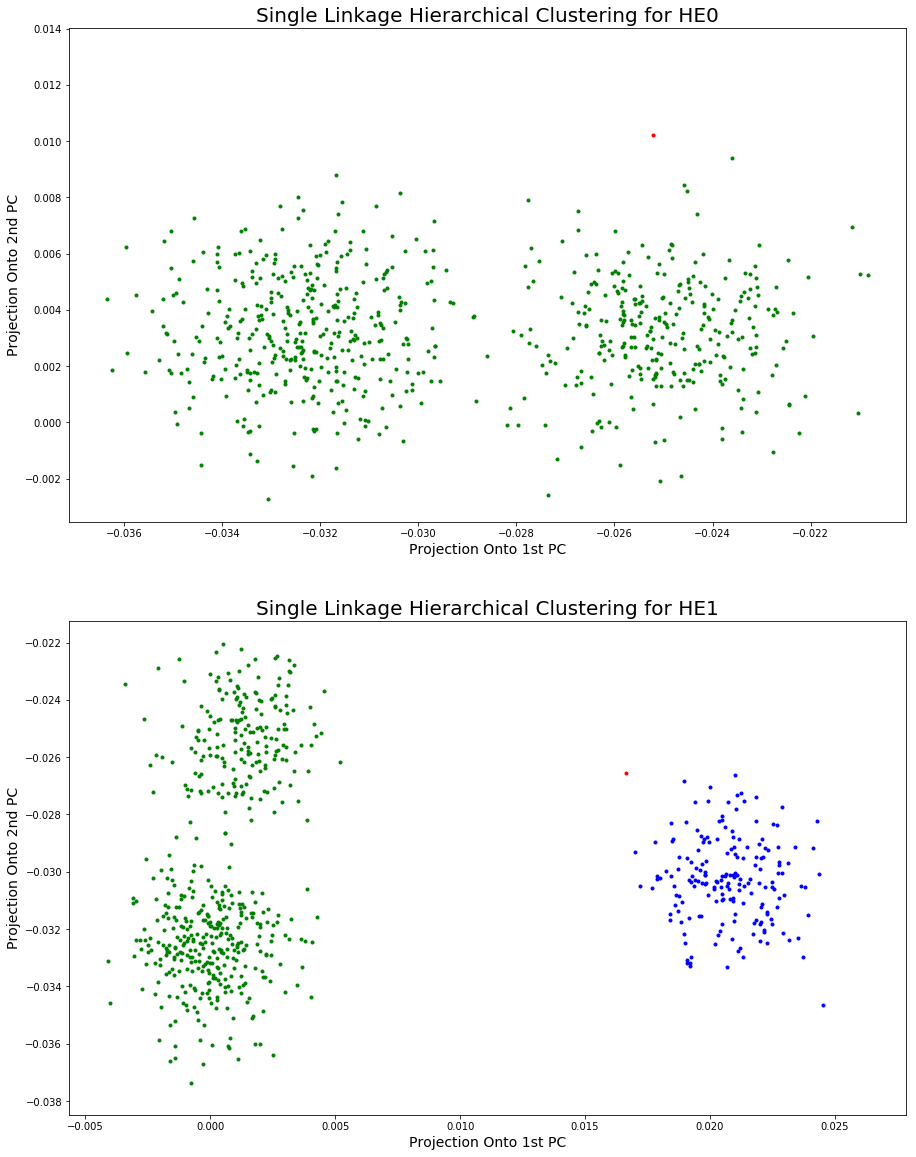

In [41]:
# Conduct k-means clustering
pointsHE0 = [[x,y] for x,y in zip(projPC1HE0, projPC2HE0)]
singleHE0 = AgglomerativeClustering(n_clusters=2, linkage="single").fit(pointsHE0)
labelsHE0 = singleHE0.labels_

pointsHE1 = [[x,y] for x,y in zip(projPC1HE1, projPC2HE1)]
singleHE1 = AgglomerativeClustering(n_clusters=3, linkage="single").fit(pointsHE1)
labelsHE1 = singleHE1.labels_

# Create two groups of indices according to the predictions
indices1HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if x])
indices2HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if not x])

indices1HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==0])
indices2HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==1])
indices3HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==2])
# Create scatter plot for HE0
fig, ax = plt.subplots(2, 1, figsize=(15,20))

ax[0].scatter(indices1HE0[:,0], indices1HE0[:,1], marker=".", color="r")
ax[0].scatter(indices2HE0[:,0], indices2HE0[:,1], marker=".", color="g")
ax[0].set_title("Single Linkage Hierarchical Clustering for HE0", fontsize=20)
ax[0].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[0].set_ylabel("Projection Onto 2nd PC", fontsize=14)

ax[1].scatter(indices1HE1[:,0], indices1HE1[:,1], marker=".", color="b")
ax[1].scatter(indices2HE1[:,0], indices2HE1[:,1], marker=".", color="g")
ax[1].scatter(indices3HE1[:,0], indices3HE1[:,1], marker=".", color="r")
ax[1].set_title("Single Linkage Hierarchical Clustering for HE1", fontsize=20)
ax[1].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[1].set_ylabel("Projection Onto 2nd PC", fontsize=14)

Text(0, 0.5, 'Projection Onto 2nd PC')

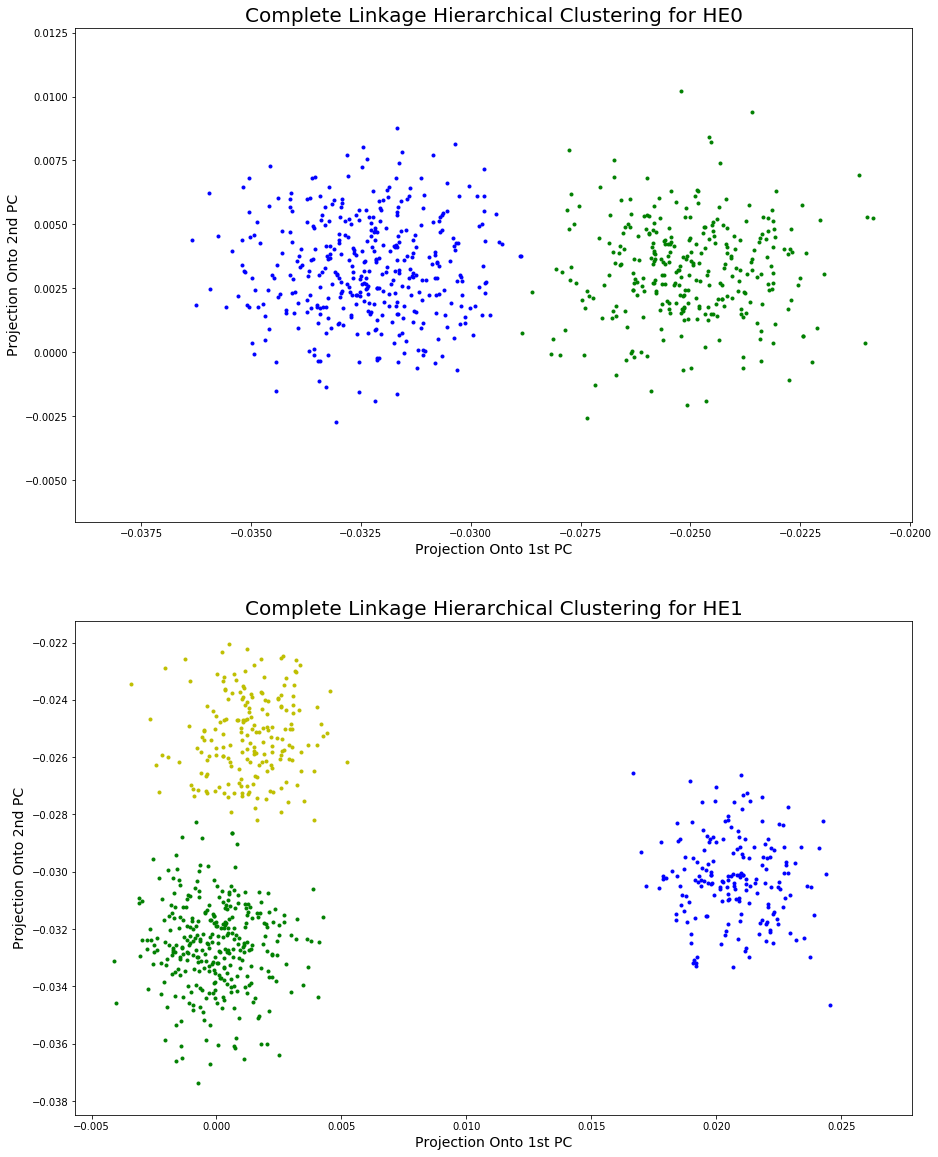

In [42]:
# Conduct k-means clustering
pointsHE0 = [[x,y] for x,y in zip(projPC1HE0, projPC2HE0)]
singleHE0 = AgglomerativeClustering(n_clusters=2, linkage="complete").fit(pointsHE0)
labelsHE0 = singleHE0.labels_

pointsHE1 = [[x,y] for x,y in zip(projPC1HE1, projPC2HE1)]
singleHE1 = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(pointsHE1)
labelsHE1 = singleHE1.labels_

# Create two groups of indices according to the predictions
indices1HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if x])
indices2HE0 = np.array([pointsHE0[i] for i,x in enumerate(labelsHE0) if not x])

indices1HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==0])
indices2HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==1])
indices3HE1 = np.array([pointsHE1[i] for i,x in enumerate(labelsHE1) if x==2])
# Create scatter plot for HE0
fig, ax = plt.subplots(2, 1, figsize=(15,20))

ax[0].scatter(indices1HE0[:,0], indices1HE0[:,1], marker=".", color="b")
ax[0].scatter(indices2HE0[:,0], indices2HE0[:,1], marker=".", color="g")
ax[0].set_title("Complete Linkage Hierarchical Clustering for HE0", fontsize=20)
ax[0].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[0].set_ylabel("Projection Onto 2nd PC", fontsize=14)

ax[1].scatter(indices1HE1[:,0], indices1HE1[:,1], marker=".", color="b")
ax[1].scatter(indices2HE1[:,0], indices2HE1[:,1], marker=".", color="g")
ax[1].scatter(indices3HE1[:,0], indices3HE1[:,1], marker=".", color="y")
ax[1].set_title("Complete Linkage Hierarchical Clustering for HE1", fontsize=20)
ax[1].set_xlabel("Projection Onto 1st PC", fontsize=14)
ax[1].set_ylabel("Projection Onto 2nd PC", fontsize=14)

### d. Single vs Complete Link Hierarchical Clustering
Discuss the differences between the single and complete linkage hierarchical clustering methods. Do you see any major differences in the generated clusters? Is there anything about our data which affects if we see a difference between the two linkage options?

In [43]:
print("Please see slides")

Please see slides


### e. Comparing Clustering Techniques
Compare your results for different clustering methods and interpret them. Select the results from one of the clusters for the following analyses. Pay close attention to the generated clusters when choosing which results to use.

In [44]:
print("Please see slides")

Please see slides


### f. What do Clusters Represent
In context, what do the clusters you have found represent? What are some factors which could account for this type of clustering pattern?

In [45]:
print("Please see slides")

Please see slides


### g. Deciding on Number of Clusters
Based on your process for deciding the number of clusters to partition the data into, what situations or factors might result in your decision being inaccurate?

In [46]:
print("Please see slides")

Please see slides


# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

In [47]:
'''
Apply K-Means Clustering Again
'''
# Conduct k-means clustering
pointsHE0 = [[x,y] for x,y in zip(projPC1HE0, projPC2HE0)]
kmeansHE0 = KMeans(n_clusters=2, random_state=0).fit(pointsHE0)
centersHE0 = np.array(kmeansHE0.cluster_centers_)

pointsHE1 = [[x,y] for x,y in zip(projPC1HE1, projPC2HE1)]
kmeansHE1 = KMeans(n_clusters=3, random_state=0).fit(pointsHE1)
centersHE1 = np.array(kmeansHE1.cluster_centers_)

# Create two groups of indices according to the predictions
labelsHE0 = kmeansHE0.labels_
predictionsHE0 = kmeansHE0.predict(pointsHE0)

### a. Determine if each HE1 Subpopulation shows altered abundance levels

In [48]:
# Reform dataframes into numpy arrays.
RAHE0_data = np.array(df_RAHE0.drop(['Microbe Name'], axis=1).values)
RAHE1_data = np.array(df_RAHE1.drop(['Microbe Name'], axis=1).values)

# Retrive data points from the original HE1 data grouped by clusters
group1HE0 = np.array([RAHE0_data[:,i] for i,x in enumerate(labelsHE0) if x]) # Data points from the 1st cluster of HE0
group2HE0 = np.array([RAHE0_data[:,i] for i,x in enumerate(labelsHE0) if not x])

group1HE1 = np.array([RAHE1_data[:,i] for i,x in enumerate(labelsHE1) if x==0]) # Data points from the 1st cluster of HE1
group2HE1 = np.array([RAHE1_data[:,i] for i,x in enumerate(labelsHE1) if x==1])
group3HE1 = np.array([RAHE1_data[:,i] for i,x in enumerate(labelsHE1) if x==2])

avgHE0 = np.average(RAHE0_data, axis=1) # The average of all data points from HE0

avg1HE1 = np.average(group1HE1, axis=0) # The average of all data points from the 1st cluster of HE1
avg2HE1 = np.average(group2HE1, axis=0)
avg3HE1 = np.average(group3HE1, axis=0)

# Define a dictionary to store the differences between the averages of clusters
differences = {"diff1": np.linalg.norm(avg1HE1-avgHE0), "diff2": np.linalg.norm(avg2HE1-avgHE0),\
               "diff3": np.linalg.norm(avg3HE1-avgHE0)}
print(differences)
print("The percentage differences for Group 1, Group 2, and Group 3 are 2.030%, 0.324%, and 0.443%, respectively. Therefore, we consider we identify the first cluster as a significantly altered cluster.")

{'diff1': 0.020304778721384406, 'diff2': 0.0032412437763563898, 'diff3': 0.00442822218410953}
The percentage differences for Group 1, Group 2, and Group 3 are 2.030%, 0.324%, and 0.443%, respectively. Therefore, we consider we identify the first cluster as a significantly altered cluster.



### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

In [54]:
from scipy import stats
print("In order to determine the similarity between a pair of one HE0 subpopulation and one HE1 subpopulation. We decided to apply two-sample t-test on each microbe of each pair. By setting significant level being 0.05, we could determine the number of microbes which have significantly altered abundance.")
print("Upon obtaining these number of different pairs respectively, we could just compare them, to decide which pair shares more similarity.")
print("The null hypothesis for each test is that: Average abundance of the microbe in two sample are the same.")
p_twoTail11 = []
for i in range(149):
    p_twoTail11.append(stats.ttest_ind(group1HE1[:, i], group1HE0[:, i], equal_var = False)[1])
alter11 = [i for i in range(149) if p_twoTail11[i] < 0.0000025]
p_twoTail12 = []
for i in range(149):
    p_twoTail12.append(stats.ttest_ind(group1HE1[:, i], group2HE0[:, i], equal_var = False)[1])
alter12 = [i for i in range(149) if p_twoTail12[i] < 0.0000025]
print("Under the two-sample t-test, The number of microbes have a altered abundance in the pair of group1HE1 and group1HE0 is:", len(alter11), "and The number of microbes have a altered abundance in the pair of group1HE1 and group2HE0 is:", len(alter12))
print("Therefore, we could say that the group1HE1 is more similar to group1HE0")

In order to determine the similarity between a pair of one HE0 subpopulation and one HE1 subpopulation. We decided to apply two-sample t-test on each microbe of each pair. By setting significant level being 0.05, we could determine the number of microbes which have significantly altered abundance.
Upon obtaining these number of different pairs respectively, we could just compare them, to decide which pair shares more similarity.
The null hypothesis for each test is that: Average abundance of the microbe in two sample are the same.
Under the two-sample t-test, The number of microbes have a altered abundance in the pair of group1HE1 and group1HE0 is: 22 and The number of microbes have a altered abundance in the pair of group1HE1 and group2HE0 is: 38
Therefore, we could say that the group1HE1 is more similar to group1HE0


### c. Identify Microbes with Significantly Altered Relative Abundance

In [51]:
from scipy import stats
from pandas.core.frame import DataFrame
np.random.seed()
count = 0
indices = []
for i in range(group1HE0.shape[1]):
    _, pvalue = stats.ks_2samp(group1HE0[:,i], group1HE1[:,i])
    if pvalue < 0.0000025:
        indices.append(i)
        count += 1

print("A total number of", count, "microbes are significantly altered")
print("Their names are:") 
Microbes = [df_RAHE0.iloc[i, 0] for i in indices]
dict = {"Microbes Index": indices, "Microbes' Name": Microbes}
df = DataFrame(dict)
display(df)

A total number of 19 microbes are significantly altered
Their names are:


,Microbes Index,Microbes' Name
0,5,Actinobacteria_Actinobacteria_Actinomycetales_...
1,11,Actinobacteria_Actinobacteria_Actinomycetales_...
2,13,Actinobacteria_Actinobacteria_Actinomycetales_...
3,20,Bacteroidetes_Bacteroidia_Bacteroidales_Bacter...
4,29,Bacteroidetes_Flavobacteriia_Flavobacteriales_...
5,33,Bacteroidetes_Sphingobacteriia_Sphingobacteria...
6,38,Chrysiogenetes_Chrysiogenetes_Chrysiogenales_C...
7,44,Firmicutes_Bacilli_Bacillales_Bacillales_Incer...
8,53,Firmicutes_Bacilli_Lactobacillales_Lactobacill...
9,63,Firmicutes_Clostridia_Clostridiales_Clostridia...


## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

In [52]:
increase = [df_RAHE0.iloc[i, 0] for i in indices if (np.mean(group1HE1[:,i]) - np.mean(group1HE0[:,i])) > 0]
increaseIdx = [i for i in indices if (np.mean(group1HE1[:,i]) - np.mean(group1HE0[:,i])) > 0]
decrease = [df_RAHE0.iloc[i, 0] for i in indices if (np.mean(group1HE1[:,i]) - np.mean(group1HE0[:,i])) < 0]
decreaseIdx = [i for i in indices if (np.mean(group1HE1[:,i]) - np.mean(group1HE0[:,i])) < 0]

dict_inc = {"Index": increaseIdx, "The names of Microbes showing an increase in HE1 sample": increase}
dict_dec = {"Index": decreaseIdx, "The names of Microbes showing a decrease in HE1 sample": decrease}
display(DataFrame(dict_inc))
display(DataFrame(dict_dec))

,Index,The names of Microbes showing an increase in HE1 sample
0,11,Actinobacteria_Actinobacteria_Actinomycetales_...
1,13,Actinobacteria_Actinobacteria_Actinomycetales_...
2,33,Bacteroidetes_Sphingobacteriia_Sphingobacteria...
3,38,Chrysiogenetes_Chrysiogenetes_Chrysiogenales_C...
4,44,Firmicutes_Bacilli_Bacillales_Bacillales_Incer...
5,78,Firmicutes_Clostridia_Halanaerobiales_Halanaer...
6,87,Parvarchaeota_Candidatus Parvarchaeum_Candidat...
7,95,Proteobacteria_Alphaproteobacteria_Rhizobiales...
8,96,Proteobacteria_Alphaproteobacteria_Rhizobiales...
9,104,Proteobacteria_Alphaproteobacteria_SAR11_SAR11


,Index,The names of Microbes showing a decrease in HE1 sample
0,5,Actinobacteria_Actinobacteria_Actinomycetales_...
1,20,Bacteroidetes_Bacteroidia_Bacteroidales_Bacter...
2,29,Bacteroidetes_Flavobacteriia_Flavobacteriales_...
3,53,Firmicutes_Bacilli_Lactobacillales_Lactobacill...
4,63,Firmicutes_Clostridia_Clostridiales_Clostridia...
5,82,Firmicutes_Negativicutes_Selenomonadales_Veill...
6,99,Proteobacteria_Alphaproteobacteria_Rhizobiales...
7,107,Proteobacteria_Betaproteobacteria_Burkholderia...
8,133,Proteobacteria_Gammaproteobacteria_Orbales_Orb...


### b. Biological Relations

In [53]:
print("Yes, there are. We could conclude from the table in 1.3 by roughly looking at their first word.")
print("Therefore, there should be six taxonomical relationships among the microbes with altered abundance. They could be categorized according to the table below.")
a = ['Actinobacteria', 'Bacteroidetes', 'Chrysiogenetes', 'Firmicutes', 'Parvarchaeota', 'Proteobacteria']
dict_1 = {"Taxonomy": a}
display(DataFrame(dict_1))

Yes, there are. We could conclude from the table in 1.3 by roughly looking at their first word.
Therefore, there should be six taxonomical relationships among the microbes with altered abundance. They could be categorized according to the table below.


,Taxonomy
0,Actinobacteria
1,Bacteroidetes
2,Chrysiogenetes
3,Firmicutes
4,Parvarchaeota
5,Proteobacteria
